<a href="https://colab.research.google.com/github/ShuichiroTsuda/Kaggle_Liverpool_Ion_Switching/blob/master/FE_crd_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import os

def load_api_key():
    with open('/content/drive/My Drive/Colab Notebooks/Kaggle/API_setup/kaggle.json') as f:
        kaggle_api_key = json.load(f)
    
    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, 'w') as f:
        json.dump(kaggle_api_key, f)

    os.chmod(filename, 600)
    print('API key loaded.')


In [27]:
load_api_key()

API key loaded.


In [28]:
!kaggle datasets download -d cdeotte/data-without-drift
!unzip data-without-drift.zip

data-without-drift.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  data-without-drift.zip
replace test_clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_clean.csv          
replace train_clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_clean.csv         


In [29]:
!kaggle competitions download -c liverpool-ion-switching
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [0]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
import lightgbm as lgb
import tensorflow.python.keras.layers as L
from tensorflow.python.keras.models import Model

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [32]:
test = pd.read_csv('test_clean.csv')
train = pd.read_csv('train_clean.csv')
test = reduce_mem_usage(test)
train = reduce_mem_usage(train)
train.head()

Mem. usage decreased to 19.07 Mb (37.5% reduction)
Mem. usage decreased to 52.45 Mb (54.2% reduction)


,time,signal,open_channels
0,0.0001,-2.759766,0
1,0.0002,-2.855469,0
2,0.0003,-2.408203,0
3,0.0004,-3.140625,0
4,0.0005,-3.152344,0


In [0]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [0]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [0]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [0]:
def calc_roll_stats(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90)
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [0]:
def calc_ewm(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [0]:
def add_features(s):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm], axis=1)

def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    return pd.concat(ls, axis=0)


In [39]:
df = divide_and_add_features(train['signal'])
df.head()

100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,roll_mean_100,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_q10_100,roll_q25_100,roll_q50_100,roll_q75_100,roll_q90_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_q10_500,roll_q25_500,roll_q50_500,roll_q75_500,roll_q90_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_q10_1000,roll_q25_1000,roll_q50_1000,roll_q75_1000,roll_q90_1000,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000
0,-0.183960,-0.006348,0.018066,-0.019653,0.001480,-0.183960,-0.186072,-0.183960,-0.186328,-0.183960,-0.186087,-0.183960,-0.185444,-0.183960,-0.184721,-0.183960,-0.184204,-0.183960,-0.183982,-0.183960,-0.183950,-0.183960,-0.183959,-0.183960,-0.183960,1.665335e-16,0.002112,-1.110223e-16,0.002366,8.326673e-17,0.002002,2.775558e-17,0.001220,0.000000,0.000481,0.000000,0.000081,0.000000,-0.000010,0.000000,...,-0.183960,0.000000,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,0.000000,-0.183960,0.000000,-0.183960,0.000000,-0.183960,0.000000,-0.183960,0.000000
1,-0.190308,0.011719,-0.001587,-0.018173,0.013489,-0.184058,-0.186054,-0.184110,-0.186344,-0.184189,-0.186156,-0.184308,-0.185589,-0.184483,-0.184984,-0.184735,-0.184635,-0.185091,-0.184506,-0.185579,-0.184091,-0.186236,-0.182781,-0.187140,-0.181272,-6.249482e-03,-0.004253,-6.189537e-03,-0.003959,-6.094421e-03,-0.004261,-5.945580e-03,-0.004947,-0.005717,-0.005528,-0.005377,-0.005753,-0.004888,-0.006022,-0.004203,...,-0.187134,0.004488,-0.190308,-0.183960,0.006348,-0.189673,-0.188721,-0.187134,-0.185547,-0.184595,-0.187134,0.004488,-0.190308,-0.183960,0.006348,-0.189673,-0.188721,-0.187134,-0.185547,-0.184595,-0.187134,0.004488,-0.190308,-0.183960,0.006348,-0.189673,-0.188721,-0.187134,-0.185547,-0.184595,-0.187451,0.004488,-0.187197,0.004488,-0.187166,0.004488,-0.187140,0.004488,-0.187137,0.004488
2,-0.160522,-0.009521,-0.018280,0.007324,0.018646,-0.183791,-0.186042,-0.183698,-0.186373,-0.183555,-0.186253,-0.183333,-0.185793,-0.182990,-0.185367,-0.182459,-0.185331,-0.181643,-0.185667,-0.180394,-0.185728,-0.178477,-0.184340,-0.175393,-0.180142,2.326832e-02,0.025520,2.316204e-02,0.025861,2.298874e-02,0.025642,2.270613e-02,0.025094,0.022246,0.024768,0.021499,0.024987,0.020295,0.025280,0.018358,...,-0.178263,0.015688,-0.190308,-0.160522,0.029785,-0.189038,-0.187134,-0.183960,-0.172241,-0.165210,-0.178263,0.015688,-0.190308,-0.160522,0.029785,-0.189038,-0.187134,-0.183960,-0.172241,-0.165210,-0.178263,0.015688,-0.190308,-0.160522,0.029785,-0.189038,-0.187134,-0.183960,-0.172241,-0.165210,-0.176626,0.016555,-0.177948,0.015867,-0.178106,0.015778,-0.178232,0.015706,-0.178248,0.015697
3,-0.209351,-0.024841,0.013062,0.019135,-0.008804,-0.183826,-0.186035,-0.183757,-0.186416,-0.183655,-0.186385,-0.183509,-0.186072,-0.183310,-0.185919,-0.183064,-0.186435,-0.182817,-0.187912,-0.182711,-0.190314,-0.183109,-0.193463,-0.184954,-0.197382,-2.552436e-02,-0.023315,-2.560371e-02,-0.022916,-2.572566e-02,-0.023027,-2.590563e-02,-0.023378,-0.026152,-0.023298,-0.026438,-0.02216

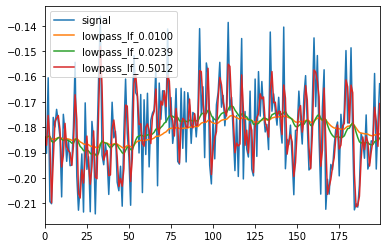

In [19]:
df[['signal',
    'lowpass_lf_0.0100',
    'lowpass_lf_0.0239',
    'lowpass_lf_0.5012']].iloc[:200].plot()

In [0]:
df['open_channels'] = train['open_channels'].values

In [52]:
df = reduce_mem_usage(df)
df['open_channels'] = train['open_channels']

Mem. usage decreased to 1079.51 Mb (72.6% reduction)


In [0]:
del train

In [0]:
df.to_pickle('/content/drive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/pkl/train_crd_1.pkl')

In [25]:
df.head()

,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_q10_100,roll_q25_100,roll_q50_100,roll_q75_100,roll_q90_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_q10_500,roll_q25_500,roll_q50_500,roll_q75_500,roll_q90_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_q10_1000,roll_q25_1000,roll_q50_1000,roll_q75_1000,roll_q90_1000,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000,open_channels
0,-0.183960,-0.006348,0.018066,-0.019653,0.001480,-0.183960,-0.186035,-0.183960,-0.186279,-0.183960,-0.186035,-0.183960,-0.185425,-0.183960,-0.184692,-0.183960,-0.184204,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,0.000000,0.002111,-0.000000,0.002367,0.000000,0.002001,0.000000,0.001221,0.000000,0.000481,0.000000,0.000081,0.000000,-0.000010,0.000000,...,0.000000,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,0.000000,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,-0.183960,0.000000,-0.183960,0.000000,-0.183960,0.000000,-0.183960,0.000000,-0.183960,0.000000,0
1,-0.190308,0.011719,-0.001587,-0.018173,0.013489,-0.184082,-0.186035,-0.184082,-0.186401,-0.184204,-0.186157,-0.184326,-0.185547,-0.184448,-0.184937,-0.184692,-0.184692,-0.185059,-0.184448,-0.185547,-0.184082,-0.186279,-0.182739,-0.187134,-0.181274,-0.006248,-0.004253,-0.006191,-0.003960,-0.006096,-0.004261,-0.005947,-0.004948,-0.005718,-0.005527,-0.005379,-0.005753,-0.004887,-0.006023,-0.004204,...,0.004490,-0.190308,-0.183960,0.006348,-0.189697,-0.188721,-0.187134,-0.185547,-0.184570,-0.187134,0.004490,-0.190308,-0.183960,0.006348,-0.189697,-0.188721,-0.187134,-0.185547,-0.184570,-0.187134,0.004490,-0.190308,-0.183960,0.006348,-0.189697,-0.188721,-0.187134,-0.185547,-0.184570,-0.187500,0.004490,-0.187256,0.004490,-0.187134,0.004490,-0.187134,0.004490,-0.187134,0.004490,0
2,-0.160522,-0.009521,-0.018280,0.007324,0.018646,-0.183838,-0.186035,-0.183716,-0.186401,-0.183594,-0.186279,-0.183350,-0.185791,-0.182983,-0.185425,-0.182495,-0.185303,-0.181641,-0.185669,-0.180420,-0.185669,-0.178467,-0.184326,-0.175415,-0.180176,0.023270,0.025513,0.023163,0.025864,0.022995,0.025635,0.022705,0.025101,0.022247,0.024765,0.021500,0.024994,0.020294,0.025284,0.018356,...,0.015686,-0.190308,-0.160522,0.029785,-0.189087,-0.187134,-0.183960,-0.172241,-0.165161,-0.178223,0.015686,-0.190308,-0.160522,0.029785,-0.189087,-0.187134,-0.183960,-0.172241,-0.165161,-0.178223,0.015686,-0.190308,-0.160522,0.029785,-0.189087,-0.187134,-0.183960,-0.172241,-0.165161,-0.176636,0.016556,-0.177979,0.015869,-0.178101,0.015778,-0.178223,0.015701,-0.178223,0.015701,0
3,-0.209351,-0.024841,0.013062,0.019135,-0.008804,-0.183838,-0.186035,-0.183716,-0.186401,-0.183716,-0.186401,-0.183472,-0.186035,-0.183350,-0.185913,-0.183105,-0.186401,-0.182861,-0.187866,-0.182739,-0.190308,-0.183105,-0.193481,-0.184937,-0.197388,-0.025528,-0.023315,-0.025604,-0.022919,-0.025726,-0.023026,-0.025909,-0.023376,-0.026154,-0.023300,-0.026443,-0.022171,-0.026642,-0.019821,-0.026382,...,0.020142,-0.209351,-0.160522,0.048828,-0.203613,-0.1

In [0]:
del df

In [0]:
df.to_pickle('/content/drive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/pkl/train_crd_1.pkl')

In [0]:
# Get train and test data
x_train, x_test, y_train, y_test = train_test_split(df.values, train['open_channels'].values, test_size=0.2)

del train, df
print('x_train.shape=', x_train.shape)
print('x_test.shape=', x_test.shape)
print('y_train.shape=', y_train.shape)
print('y_test.shape=', y_test.shape)

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

print('class_weights=', class_weights)
class_weight = {int(k): class_weights[k] for k in range(len(class_weights))}
print('class_weight=', class_weight)

class_weights= [ 0.36656448  0.46104095  0.82116655  0.67917745  1.12673359  1.63505559
  2.41732886  1.71592957  1.85386879  3.34040385 12.74530734]
class_weight= {0: 0.36656448070826125, 1: 0.46104094516160005, 2: 0.821166553311467, 3: 0.6791774549760531, 4: 1.126733585252184, 5: 1.6350555918901242, 6: 2.4173288636922643, 7: 1.7159295748183903, 8: 1.8538687924362154, 9: 3.3404038548260484, 10: 12.7453073371548}


In [0]:
def create_mpl(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(150, activation='relu')(X)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model


mlp = create_mpl(x_train[0].shape)
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(mlp.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 105)]             0         
_________________________________________________________________
dense (Dense)                (None, 150)               15900     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 125)               18875     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               12600     
_________________________________________________________________
dense_4 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3800  

In [0]:
# fit the model
mlp.fit(x=x_train, y=y_train, epochs=30, batch_size=1024, class_weight=class_weight)

Epoch 1/30
3907/3907 [==============================] - 73s 19ms/step - loss: 0.1400 - sparse_categorical_accuracy: 0.2726
Epoch 2/30
3907/3907 [==============================] - 73s 19ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.2817
Epoch 3/30
3907/3907 [==============================] - 74s 19ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.2827
Epoch 4/30
3907/3907 [==============================] - 73s 19ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.2830
Epoch 5/30
3907/3907 [==============================] - 73s 19ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.2834
Epoch 6/30
3907/3907 [==============================] - 74s 19ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.2837
Epoch 7/30
3907/3907 [==============================] - 73s 19ms/step - loss: 0.1010 - sparse_categorical_accuracy: 0.2839
Epoch 8/30
3907/3907 [==============================] - 72s 18ms/step - loss: 0.1010 - sparse_categorical_accuracy: 0.2839
Epoch 9/30
3907/

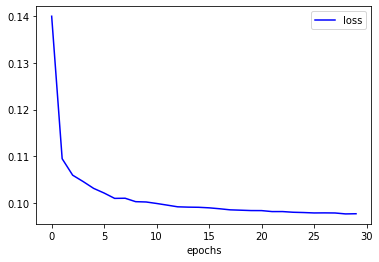

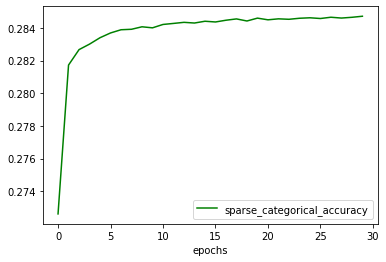

In [0]:
# plot history
plt.figure(1)
plt.plot(mlp.history.history['loss'], 'b', label='loss')
plt.xlabel('epochs')
plt.legend()
plt.figure(2)
plt.plot(mlp.history.history['sparse_categorical_accuracy'], 'g', label='sparse_categorical_accuracy')
plt.xlabel('epochs')
plt.legend()

In [0]:
mlp_pred = mlp.predict(x_test)
print('mlp_pred.shape=', mlp_pred.shape)